* Plot radio dynamic spectra from ORFEES and NenuFAR.
* Plot timeseries of STIX, ORFEES, and NenuFAR.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

machine = 'nancep' # dias or nancep

if machine=='dias': # on dias machines
    data_dir = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir = '/home/mnedal/data'
    folder_path = '/home/mnedal/outputs/data'
    outputs = '/home/mnedal/outputs/plots'

In [2]:
mydate = '2025-03-25'

year, month, day = mydate.split('-')

In [6]:
orfees_filename = f'{folder_path}/orfees/orfees_{mydate}.pkl'

if os.path.exists(orfees_filename):
    print('ORFEES DataFrame exists, loading it ..')
    df_orfees = pd.read_pickle(orfees_filename)
    display(df_orfees.head(3)) # sanity check

else:
    print('ORFEES DataFrame not exist, making one ..')
    files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')
    
    orfees = fits.open(files[0])
    orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
    orfees_data = orfees_i.T
    
    orfees_time_str = orfees[0].header['DATE-OBS']
    orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
    orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz
    
    # convert ORFEES data to a DataFrame and plot it to determine the quiet period, which will be divided by later.
    df_orfees = pd.DataFrame(data=orfees_data, index=orfees_times, columns=orfees_freqs.value.flatten())
    df_orfees.index = [t.datetime for t in df_orfees.index]
    display(df_orfees.head(3)) # sanity check
    
    # Export the ORFEES spectrum .. TO-DO: MOVE THIS PART TO THE OTHER NOTEBOOK OF ORFEES PROCESSING)
    df_orfees.to_pickle(orfees_filename)

ORFEES DataFrame not exist, making one ..


,144.130005,144.520004,144.910004,145.300003,145.690002,146.960007,148.089996,148.429993,148.820007,149.210007,...,990.729980,992.289978,993.859985,995.419983,996.979980,998.539978,1000.109985,1001.669983,1003.229980,1004.700012
2025-03-25 06:56:06.740,38.740002,49.170002,55.987503,53.974998,55.317501,52.805,53.143330,54.192501,55.035000,54.482498,...,42.108749,41.434372,46.627499,44.325623,40.367504,47.371876,46.206249,51.374996,53.906246,70.457146
2025-03-25 06:56:06.840,40.230003,50.660000,53.490002,52.929996,54.639999,53.625,53.639999,53.817501,53.162498,53.737503,...,42.108749,42.340622,46.627499,44.325623,41.341877,47.371876,47.474998,51.374996,53.906246,70.457146
2025-03-25 06:56:06.940,47.680000,55.130001,54.782501,53.974998,55.472500,54.430,53.639999,54.192501,53.910000,54.850002,...,42.108749,42.787498,46.627499,41.891243,39.887505,47.371876,47.493752,52.293747,53.906246,70.457146


In [ ]:
# v_range = np.nanpercentile(df_orfees, [1,96])

# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees.index, df_orfees.columns, df_orfees.T,
#                    vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [ ]:
# start_time = pd.to_datetime('2025-03-25T12:00:00')
# end_time   = pd.to_datetime('2025-03-25T13:00:00')

# start_nearest = df_orfees.index.asof(start_time)
# end_nearest   = df_orfees.index.asof(end_time)

# df_sliced = df_orfees.loc[start_nearest:end_nearest]

# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_sliced.index, df_sliced.columns, df_sliced.T,
#                    vmin=0, vmax=150, cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [ ]:
# bkg_removal_method = 1

# if bkg_removal_method==1:
#     print('Find the exact or earlier timestamps, and slice at this window')
#     start_time = pd.to_datetime('2025-03-25T07:00:00')
#     end_time   = pd.to_datetime('2025-03-25T07:15:00')
    
#     start_nearest = df_orfees.index.asof(start_time)
#     end_nearest   = df_orfees.index.asof(end_time)
    
#     subdf = df_orfees.loc[start_nearest:end_nearest]
#     df_sliced = subdf.mean(axis=0)
#     # print(start_nearest, end_nearest, sep='\n')
#     print('Remove the background by dividing the data by the quiet background')
#     df_orfees_nobkg = df_orfees/df_sliced

# elif bkg_removal_method==2:
#     print('### Find the nearest row to a single timestamp')
#     start_time = pd.to_datetime('2025-03-25T07:00:00')
    
#     nearest_idx = df_orfees.index.get_indexer([start_time], method='nearest')[0]
#     df_sliced = df_orfees.iloc[nearest_idx]
    
#     actual_time = df_orfees.index[nearest_idx]
#     # print(actual_time)
#     print('Remove the background by dividing the data by the quiet background')
#     df_orfees_nobkg = df_orfees/df_sliced

In [ ]:
# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_nobkg.index, df_orfees_nobkg.columns, df_orfees_nobkg.T,
#                    # vmin=v_range[0], vmax=v_range[1],
#                    vmin=0, vmax=1,
#                    cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [ ]:
# # Downsample to 1-s for faster inspection
# df_orfees_1s = df_orfees.resample('1S').mean()

In [ ]:
# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
#                    norm=LogNorm(vmin=1e1, vmax=1e3),
#                    # norm=LogNorm(vmin=np.nanpercentile(df_orfees_1s, 0), vmax=np.nanpercentile(df_orfees_1s, 90)),
#                    cmap='Spectral_r') # Greys
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [ ]:
# ### clean the data by subtracting the mean
# # calculate the mean intensity in each row (freq channel)
# df_mean = df_orfees_1s.mean(axis=1)
# # subtract that mean value from each corresponding row
# df_submean = df_orfees_1s.sub(df_mean, axis=0)

# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_submean.index, df_submean.columns, df_submean.T,
#                    # norm=LogNorm(vmin=1e1, vmax=1e3),
#                    vmin=np.nanpercentile(df_submean, 0), vmax=np.nanpercentile(df_submean, 90),
#                    cmap='Spectral_r') # Greys
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

## Load NenuFAR data

In [9]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
nenufar_files

['/home/mnedal/outputs/data/nenufar/combined_spectra_2025-03-25_typeII.pkl',
 '/home/mnedal/outputs/data/nenufar/combined_spectra_2025-03-25_typeIII_G1.pkl',
 '/home/mnedal/outputs/data/nenufar/combined_spectra_2025-03-25_typeIII_G2.npz',
 '/home/mnedal/outputs/data/nenufar/combined_spectra_2025-03-25_typeIII_G3.npz',
 '/home/mnedal/outputs/data/nenufar/combined_spectra_2025-03-25_typeIII_G4.pkl']

In [11]:
SRB_groupname = nenufar_files[4].split(f'{mydate}_')[-1].split('.')[0]
print(SRB_groupname)

df_nenufar = pd.read_pickle(nenufar_files[4])

typeIII_G4


In [12]:
# v_range = np.nanpercentile(df_nenufar, [7, 99.97])

# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
#                    vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [13]:
# # slice nenufar to match orfees
# start_time = pd.to_datetime(df_nenufar.index[0])
# end_time   = pd.to_datetime(df_nenufar.index[-1])

# start_nearest = df_orfees.index.asof(start_time)
# end_nearest   = df_orfees.index.asof(end_time)

# subdf_orfees = df_orfees.loc[start_nearest:end_nearest]
# print(subdf_orfees.index[0], subdf_orfees.index[-1])

In [14]:
# fig = plt.figure(figsize=[10,8])

# v_range = np.nanpercentile(df_nenufar, [7, 99.97])
# ax = fig.add_subplot(211)
# pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
#                    vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_ylim(ax.get_ylim()[::-1])
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# v_range = np.nanpercentile(subdf_orfees, [1, 90])
# ax = fig.add_subplot(212)
# pc = ax.pcolormesh(subdf_orfees.index, subdf_orfees.columns, subdf_orfees.T,
#                    vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# fig.tight_layout()
# plt.show()

In [15]:
# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
#                    norm=LogNorm(vmin=1e1, vmax=1e3), cmap='Greys')
# fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

### Option 1: Use a single reference level (e.g., median of all values)

In [16]:
# # Avoid log(0) or log of negative numbers
# sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# # Global reference (e.g., median of entire dataset)
# P_ref = sfu_data_clipped.median().median()

# # Convert to dB
# db_data = 10 * np.log10(sfu_data_clipped / P_ref)

# # Clean up result
# db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
#                    vmin=0, vmax=2, cmap='Greys')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

### Option 2: Use a reference per frequency (i.e., per column)

In [17]:
# # Avoid log(0) or log of negative numbers
# sfu_data_clipped = df_orfees_1s.clip(lower=1e-10)

# # Column-wise (per frequency) reference: median per column
# P_ref_per_freq = sfu_data_clipped.median(axis=0)  # Series of shape (num_columns,)

# # Broadcasting across rows
# db_data = 10 * np.log10(sfu_data_clipped.div(P_ref_per_freq, axis='columns'))

# # Clean up result
# db_data.replace([-np.inf, np.inf], np.nan, inplace=True)

# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(db_data.index, db_data.columns, db_data.T,
#                    vmin=0, vmax=0.8, cmap='Greys')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [18]:
# # Downsample to 1-min resolution
# df_orfees_1min = db_data.resample('1min').mean()

In [19]:
# v_range = np.nanpercentile(df_orfees_1min, [50,96])

# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1min.index, df_orfees_1min.columns, df_orfees_1min.T,
#                    # vmin=v_range[0], vmax=v_range[1],
#                    vmin=0, vmax=0.8,
#                    cmap='Greys')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [20]:
# np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms')).astype('int')

# Calibration Strategy

## 1. Downsample NenuFAR in time to match ORFEES time resolution

In [21]:
nenufar_cadence = np.median(np.diff(df_nenufar.index)/np.timedelta64(1,'ms'))
orfees_cadence = np.median(np.diff(df_orfees.index)/np.timedelta64(1,'ms'))#.astype('int')

print(f'Downsampling NenuFAR (dt = {nenufar_cadence} ms) to ORFEES cadence (dt = {orfees_cadence} ms)')

nenufar_db_down = df_nenufar.resample(f'{orfees_cadence}ms').mean()

assert np.median(np.diff(nenufar_db_down.index)/np.timedelta64(1,'ms')) == orfees_cadence, 'NenuFAR cadence does not match ORFEES cadence! Check the resampling.'

Downsampling NenuFAR (dt = 20.972 ms) to ORFEES cadence (dt = 100.0 ms)


## 2. Automatically detect quiet periods

In [22]:
def find_quiet_periods(df, window='10S', quant=0.1, std_thresh=None, use_median=True, iqr_multiplier=1.5):
    """
    Identify quiet times in a radio spectrogram based on low spectral variability.

    Parameters:
        df (pd.DataFrame): 2D data with shape (time, frequency) in SFU units.
        window (str): Rolling window size (e.g., '10S' for 10 seconds).
        quant (float): Quantile to use when estimating std_thresh if not provided.
        std_thresh (float or None): If provided, use this absolute threshold for std.
        use_median (bool): Whether to aggregate std across frequencies using median (more robust) or mean.
        iqr_multiplier (float): Multiplier for IQR if using automated thresholding based on boxplot rule.

    Returns:
        pd.DatetimeIndex: Timestamps of detected quiet periods.
    """
    rolling_std = df.rolling(window).std()
    agg_std = rolling_std.median(axis=1) if use_median else rolling_std.mean(axis=1)

    if std_thresh is None:
        Q1 = agg_std.quantile(0.25)
        Q3 = agg_std.quantile(0.75)
        IQR = Q3 - Q1
        std_thresh = Q1 - iqr_multiplier * IQR

    quiet_times = df.index[agg_std < std_thresh]
    return quiet_times

## 3. Apply to ORFEES and Convert SFU to dB

In [23]:
# Find quiet times in ORFEES
quiet_times_orf = find_quiet_periods(df_orfees, window='10S', iqr_multiplier=1.5)

# Compute median power level in quiet time — used as dB reference
orf_ref_sfu = df_orfees.loc[quiet_times_orf].median().median()

# Convert SFU to dB
orfees_db = 10 * np.log10(df_orfees / orf_ref_sfu)

In [24]:
# # Downsample to 1-s resolution
# df_orfees_1s = orfees_db.resample('1S').mean()

In [25]:
# fig = plt.figure(figsize=[15,5])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
#                    vmin=0, vmax=5, cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

In [26]:
print('NenuFAR time range:', nenufar_db_down.index[0], 'to', nenufar_db_down.index[-1])
print('ORFEES time range:', orfees_db.index[0], 'to', orfees_db.index[-1])

NenuFAR time range: 2025-03-25 10:45:00 to 2025-03-25 10:49:00
ORFEES time range: 2025-03-25 06:56:06.740000 to 2025-03-25 16:53:15.840000


## 4. Slice ORFEES to match NenuFAR

In [36]:
start_time = pd.to_datetime(nenufar_db_down.index[0])
end_time   = pd.to_datetime(nenufar_db_down.index[-1])

start_nearest = orfees_db.index.asof(start_time)
end_nearest   = orfees_db.index.asof(end_time)

subdf_orfees_db = orfees_db.loc[start_nearest:end_nearest]
subdf_orfees_db.index[0], subdf_orfees_db.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

In [37]:
dt_start = np.abs(nenufar_db_down.index[0] - subdf_orfees_db.index[0]).total_seconds()*u.s.to('ms')
dt_end = np.abs(nenufar_db_down.index[-1] - subdf_orfees_db.index[-1]).total_seconds()*u.s.to('ms')

print(f'Difference in start times: {dt_start} ms')
print(f'Difference in end times: {dt_end} ms')

Difference in start times: 60.0 ms
Difference in end times: 60.0 ms


## 5. Remap NenuFAR onto ORFEES time grid to align their timestamps

In [29]:
# Ensure both time indices are sorted (safe practice)
nenufar_df = nenufar_db_down.sort_index()
orfees_df = subdf_orfees_db.sort_index()

# Convert time indices to seconds since epoch for numerical interpolation
nenufar_time = nenufar_df.index.view(np.int64) / 1e9  # float64 seconds
orfees_time = orfees_df.index.view(np.int64) / 1e9

# Prepare the output DataFrame with ORFEES time index
nenufar_remapped = pd.DataFrame(index=orfees_df.index, columns=nenufar_df.columns)

# Interpolate each frequency channel individually
for freq in nenufar_df.columns:
    nenufar_remapped[freq] = np.interp(
        orfees_time,
        nenufar_time,
        nenufar_df[freq].values
    )

## 6. Remove constant background

In [30]:
subdf_orfees_db_nobkg = subdf_orfees_db - np.tile(np.median(subdf_orfees_db,0), (subdf_orfees_db.shape[0],1))
nenufar_remapped_nobkg = nenufar_remapped - np.tile(np.median(nenufar_remapped,0), (nenufar_remapped.shape[0],1))

In [31]:
# fig = plt.figure(figsize=[10,8])

# # v_range = np.nanpercentile(nenufar_db_down, [1, 99])
# ax = fig.add_subplot(211)
# pc = ax.pcolormesh(nenufar_remapped_nobkg.index, nenufar_remapped_nobkg.columns, nenufar_remapped_nobkg.T,
#                    # vmin=v_range[0], vmax=v_range[1],
#                    vmin=0, vmax=30,
#                    cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_ylim(ax.get_ylim()[::-1])
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

# # v_range = np.nanpercentile(subdf_orfees_db, [10, 97])
# ax = fig.add_subplot(212)
# pc = ax.pcolormesh(subdf_orfees_db_nobkg.index, subdf_orfees_db_nobkg.columns, subdf_orfees_db_nobkg.T,
#                    # vmin=v_range[0], vmax=v_range[1],
#                    vmin=0, vmax=1,
#                    cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_xlabel(f'Time (MM:SS) starting from {nenufar_db_down.index[0].time().hour}:00:00 UT')
# ax.set_ylabel('Frequency (MHz)')
# ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[::-1])
# yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax.set_yticks(yticks)
# ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

# fig.tight_layout()
# plt.show()

## 7. Combine both NenuFAR and ORFEES spectra

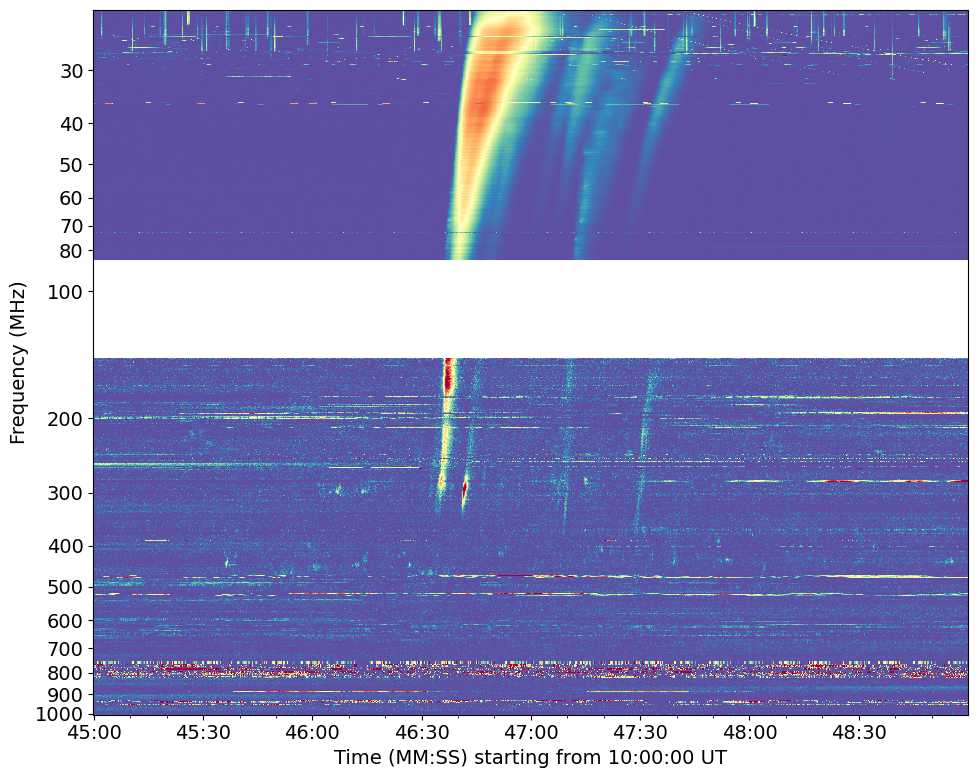

In [32]:
fig = plt.figure(figsize=[10,8])
ax  = fig.add_subplot(111)

# Top panel: NenuFAR
ax.pcolormesh(nenufar_remapped_nobkg.index, nenufar_remapped_nobkg.columns,
              nenufar_remapped_nobkg.T, vmin=0, vmax=30, cmap='Spectral_r', alpha=1)

# Bottom panel: ORFEES
ax.pcolormesh(subdf_orfees_db_nobkg.index, subdf_orfees_db_nobkg.columns,
              subdf_orfees_db_nobkg.T, vmin=0, vmax=1, cmap='Spectral_r', alpha=1)

# Axes settings
ax.set_xlabel(f'Time (MM:SS) starting from {nenufar_db_down.index[0].time().hour}:00:00 UT')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending

# Tick settings
custom_ticks = [30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(custom_ticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

fig.tight_layout()
plt.show()

In [33]:
if not os.path.exists(f'{outputs}/nenufar_orfees_dyspec_{mydate}_{SRB_groupname}.png'):
    fig.savefig(f'{outputs}/nenufar_orfees_dyspec_{mydate}_{SRB_groupname}.png', format='png', dpi=300, bbox_inches='tight')

In [34]:
# # Plot in linear scale with a smaller top panel
# fig, (ax1, ax2) = plt.subplots(
#     2, 1, figsize=[10, 8],
#     sharex=True,
#     gridspec_kw={'height_ratios': [1, 2]}  # Top panel is smaller
# )

# # Top panel: NenuFAR
# pcm1 = ax1.pcolormesh(nenufar_remapped_nobkg.index, nenufar_remapped_nobkg.columns,
#                       nenufar_remapped_nobkg.T, vmin=0, vmax=30, cmap='Spectral_r')
# # ax1.set_yscale('log')
# ax1.set_ylim(ax1.get_ylim()[::-1])
# ax1.set_ylabel('Freq (MHz)')
# ax1.set_yticks([30, 40, 50, 60, 70, 80])
# ax1.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(n=10))

# # Bottom panel: ORFEES
# pcm2 = ax2.pcolormesh(subdf_orfees_db_nobkg.index, subdf_orfees_db_nobkg.columns,
#                       subdf_orfees_db_nobkg.T, vmin=0, vmax=1, cmap='Spectral_r')
# # # ax2.set_yscale('log')
# ax2.set_ylim(ax2.get_ylim()[::-1])
# ax2.set_xlabel(f'Time (MM:SS) starting from {nenufar_db_down.index[0].time().hour}:00:00 UT')
# ax2.set_ylabel('Freq (MHz)')
# custom_ticks = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ax2.set_yticks(custom_ticks)
# ax2.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
# ax2.yaxis.set_minor_locator(AutoMinorLocator(n=10))
# ax2.xaxis.set_minor_locator(AutoMinorLocator(n=3))
# ax2.xaxis_date()
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

# fig.tight_layout()
# plt.show()

## 8. Plot STIX lightcurves

In [38]:
nenufar_remapped_nobkg.index[0], nenufar_remapped_nobkg.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

In [39]:
start_time = nenufar_remapped_nobkg.index[0]
end_time   = nenufar_remapped_nobkg.index[-1]

sci_query = Fido.search(a.Time(start_time, end_time),
                        a.Instrument.stix, a.stix.DataType.sci)

sci_files = Fido.fetch(sci_query)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [11]:
dyspec = Product(sci_files)

energy_indices = [[1,6], [7,11], [12,16], [17,22], [23,27]]
mytuple = dyspec.get_data(detector_indices=[[0,31]], pixel_indices=[[0,11]], energy_indices=energy_indices)
flux, _, times, _, energy_bins = mytuple
dE = energy_bins['e_high'] - energy_bins['e_low']
# stix_flux = np.array([ dyspec.data['counts'][...,lo:hi].sum(axis=1)/dyspec.duration.to('s') for lo, hi in energy_indices ]).T / dE
# stix_flux = np.array([ dyspec.data['counts'][...,lo:hi].sum(axis=1)/dyspec.duration.to('s') for lo, hi in energy_indices ]).T
stix_flux = [ dyspec.data['counts'][...,lo:hi].sum(axis=1)/dyspec.duration.to('s') for lo, hi in energy_indices ]

# Apply the time-delay shift
stix_time       = dyspec.times.datetime
tmp1            = [ Time(t) + (dyspec.meta['EAR_TDEL'])*u.s for t in stix_time ]
tmp2            = np.array(tmp1)
stix_time_shift = [ t.datetime for t in tmp2 ] # final timestamps

NameError: name 'sci_files' is not defined

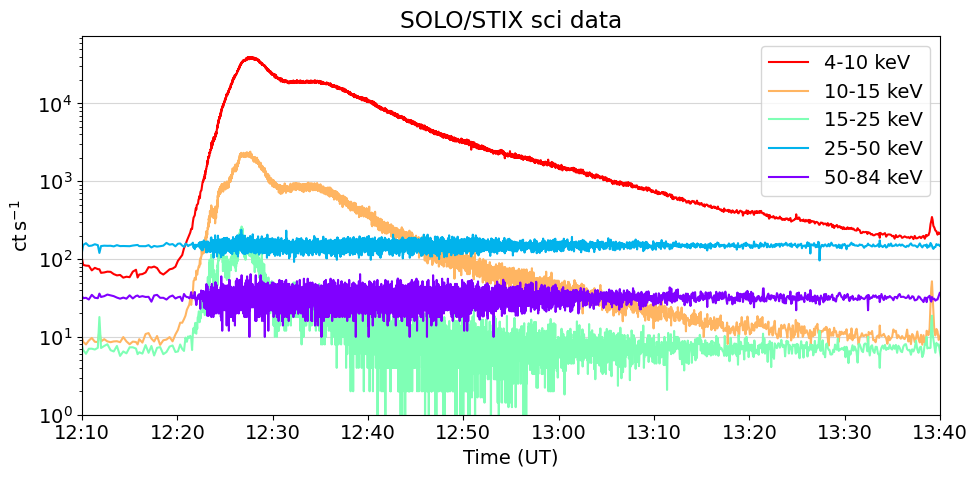

In [41]:
energy_bands = []
for i, j in zip(energy_bins['e_low'], energy_bins['e_high']):
    low_energy  = i.value.astype('int')
    high_energy = j.value.astype('int')
    energy_bands.append(f'{low_energy}-{high_energy} keV')

cmap        = plt.cm.get_cmap('rainbow_r') # Blues, Greens, Reds, Grays, rainbow, Spectral
num_lines   = len(stix_flux)
colors_list = cmap(np.linspace(0, 1, num_lines))


fig = plt.figure(figsize=[10,5])
ax  = fig.add_subplot(111)

for i in range(len(stix_flux)):
    # ax.plot(stix_time_shift, stix_flux[:,i], color=colors_list[i], label=energy_bands[i])
    ax.plot(stix_time_shift, stix_flux[i], color=colors_list[i], label=energy_bands[i])
    # ax.plot(stix_time_shift, stix_flux[i]/dE[i], color=colors_list[i], label=energy_bands[i])

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
# ax.set_ylabel(r'count s$^{-1}$ keV$^{-1}$')
ax.set_title(dyspec.meta['TELESCOP']+' sci data')
ax.legend(loc='upper right')
# ax.set_xlim(left=start_time, right=end_time)
# ax.set_xlim(left=pd.Timestamp(start_time)-timedelta(minutes=21), right=end_time)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.set_ylim(bottom=10**0)
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid(axis='y', alpha=0.5)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=[10,12])

ax = fig.add_subplot(211)

# Top panel: NenuFAR
ax.pcolormesh(nenufar_remapped_nobkg.index, nenufar_remapped_nobkg.columns,
              nenufar_remapped_nobkg.T, vmin=0, vmax=30, cmap='Spectral_r', alpha=1)

# Bottom panel: ORFEES
ax.pcolormesh(subdf_orfees_db_nobkg.index, subdf_orfees_db_nobkg.columns,
              subdf_orfees_db_nobkg.T, vmin=0, vmax=1, cmap='Spectral_r', alpha=1)

# Axes settings
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending

# Tick settings
custom_ticks = [30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(custom_ticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

# STIX
ax = fig.add_subplot(212)
for i in range(len(stix_flux)):
    ax.plot(stix_time_shift, stix_flux[i], color=colors_list[i], label=energy_bands[i])

ax.set_yscale('log')
ax.grid(axis='y', alpha=0.5)
ax.legend(loc='upper right')
ax.set_xlabel(f'Time (MM:SS) starting from {nenufar_db_down.index[0].time().hour}:00:00 UT')
ax.set_xlim(left=nenufar_remapped_nobkg.index[0], right=nenufar_remapped_nobkg.index[-1])
ax.set_ylim(bottom=10**0)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

fig.tight_layout()
plt.show()

In [ ]:
# Make the DataFrame
df = pd.DataFrame(flux_arr, columns=energy_bands, index=times_arr)
df.head()

In [ ]:
# start_time = nenufar_remapped_nobkg.index[0]
# end_time   = nenufar_remapped_nobkg.index[-1]

# sci_query = Fido.search(a.Time(start_time, end_time),
#                         a.Instrument.stix, a.stix.DataType.sci)

# sci_files = Fido.fetch(sci_query)
# dyspec = Product(sci_files)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# dyspec.plot_spectrogram(axes=ax)
# im = [obj for obj in ax.get_children() if isinstance(obj, QuadMesh)][-1]
# cbar = fig.colorbar(im, ax=ax, pad=0.02)
# cbar.set_label(dyspec.meta['BUNIT'])
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
# ax.set_xlim(left=start_time, right=end_time)
# fig.tight_layout()
# plt.show()

In [ ]:
# mytuple = dyspec.get_data(detector_indices=[[0,31]], pixel_indices=[[0,11]], energy_indices=[[1,6], [7,11], [12,16], [17,22], [23,27]])

# # Unpack the tuple
# flux, _, times, _, energy_bins = mytuple

# times_arr = times.datetime

# energy_bands = []
# for i, j in zip(energy_bins['e_low'], energy_bins['e_high']):
#     low_energy  = i.value.astype('int')
#     high_energy = j.value.astype('int')
#     energy_bands.append(f'{low_energy}-{high_energy} keV')

# # Squeeze and scale the flux array (shape: N_times, 5)
# scale_factor = 400
# flux_arr = (flux.squeeze() * scale_factor).value  # convert to numpy array if it's still a Quantity
# # flux_arr = (flux.squeeze()).value

# # Get datetime values for the index
# times_arr = times.datetime

# # Make the DataFrame
# df = pd.DataFrame(flux_arr, columns=energy_bands, index=times_arr)
# df.head()

In [ ]:
# Convert DataFrame index to Time object
time_obj = Time(df.index.to_pydatetime())
time_shifted = time_obj + (dyspec.meta['EAR_TDEL'])*u.s
time_shifted = time_shifted.datetime

In [ ]:
fig = plt.figure(figsize=[10,5])
ax  = fig.add_subplot(111)

cmap        = plt.cm.get_cmap('Spectral') # Spectral, gist_rainbow, nipy_spectral, gist_ncar, Blues
num_lines   = len(df.columns)
colors_list = cmap(np.linspace(0, 1, num_lines))

for i, col in enumerate(df.columns):
    ax.plot(time_shifted, df[col], color=colors_list[i], label=col)

ax.set_yscale('log')
# ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'count s$^{-1}$ keV$^{-1}$')
ax.set_title(dyspec.meta['TELESCOP']+' sci data')
ax.legend(loc='upper right')
# ax.set_xlim(left=start_time, right=end_time)
# ax.set_xlim(left=pd.Timestamp(start_time)-timedelta(minutes=21), right=end_time)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.set_ylim(bottom=10**0)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.grid(axis='y', alpha=0.5)
fig.tight_layout()
plt.show()

In [ ]:
start_time = '2025-03-25T12:21:00'
end_time   = '2025-03-25T13:12:00'

ql_query = Fido.search(a.Time(start_time, end_time),
                       a.Instrument.stix, a.stix.DataProduct.ql_lightcurve)
ql_files = Fido.fetch(ql_query)
ql_lightcurves = Product(ql_files)

In [ ]:
flux_ql_lc = ql_lightcurves.data['counts']/ql_lightcurves.data['timedel'].reshape(-1, 1).to('s')
dt_ql_lc   = pd.to_datetime(ql_lightcurves.data['time'].datetime)

# do timedelay correction and convert to datetime objects
files = fits.open(ql_files[0])
ql_shifted_times = dt_ql_lc + timedelta(seconds=files[0].header['EAR_TDEL'])

In [ ]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
ax.plot(ql_shifted_times, flux_ql_lc, label=df.columns)
ax.legend()
ax.semilogy()
ax.grid(axis='y', alpha=0.5)
ax.set_title('QL data')
ax.set_ylim(bottom=10**0)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [ ]:
dyspec.data['timedel']

In [ ]:
plt.figure(figsize=[10,4])
plt.plot(dyspec.data['timedel'])

In [ ]:
fig = plt.figure(figsize=[10,10])

ax = fig.add_subplot(211)

# Top panel: NenuFAR
ax.pcolormesh(nenufar_remapped_nobkg.index, nenufar_remapped_nobkg.columns,
              nenufar_remapped_nobkg.T, vmin=0, vmax=30, cmap='Spectral_r', alpha=1)

# Bottom panel: ORFEES
ax.pcolormesh(subdf_orfees_db_nobkg.index, subdf_orfees_db_nobkg.columns,
              subdf_orfees_db_nobkg.T, vmin=0, vmax=1, cmap='Spectral_r', alpha=1)

ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
custom_ticks = [30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(custom_ticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))


ax = fig.add_subplot(212)

# STIX
for i, col in enumerate(df.columns):
    ax.plot(time_shifted, df[col], color=colors_list[i], label=col)

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'count s$^{-1}$ keV$^{-1}$')
ax.set_title(dyspec.meta['TELESCOP'])
ax.legend(loc='upper right')
ax.set_xlim(left=start_time, right=end_time)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.grid(axis='y', alpha=0.5)

ax.set_xlabel(f'Time (MM:SS) starting from {nenufar_db_down.index[0].time().hour}:00:00 UT')

fig.tight_layout()
plt.show()

In [ ]:
sci_query = Fido.search(a.Time(start_time, end_time),
                        a.Instrument.stix, a.stix.DataType.sci)
sci_files = Fido.fetch(sci_query)
dyspec = Product(sci_files[0])

ql_lc_query = Fido.search(a.Time(start_time, end_time),
                          a.Instrument.stix, a.stix.DataProduct.ql_lightcurve)
ql_lc_files = Fido.fetch(ql_lc_query)
ql_lc = Product(ql_lc_files[0])

dt_ql_lc = pd.to_datetime(ql_lc.data['time'].datetime)
dt_dyspec = pd.to_datetime(dyspec.times.datetime)

In [ ]:
flux_ql_lc = ql_lc.data['counts']/ql_lc.data['timedel'].reshape(-1, 1).to('s')
flux_dyspec = np.array([dyspec.data['counts'][...,lo:hi].sum(axis=(1))/dyspec.duration.to('s')
                        for lo, hi in [[1,6], [7,11], [12,16], [17,22], [23,27]]]).T

In [ ]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
ax.plot(dt_dyspec, flux_dyspec)
ax.plot(dt_ql_lc, flux_ql_lc)
ax.legend()
ax.semilogy()
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=10**0)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [3]:
from sunpy.timeseries import TimeSeries
from stixpy.timeseries import *

start_time = '2025-03-25 10:45:00'
end_time   = '2025-03-25 10:49:00'

ql_query = Fido.search(a.Time(start_time, end_time),
                       a.Instrument.stix, a.stix.DataProduct.ql_lightcurve)
ql_lc_files = Fido.fetch(ql_query)
ts = TimeSeries(ql_lc_files[0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

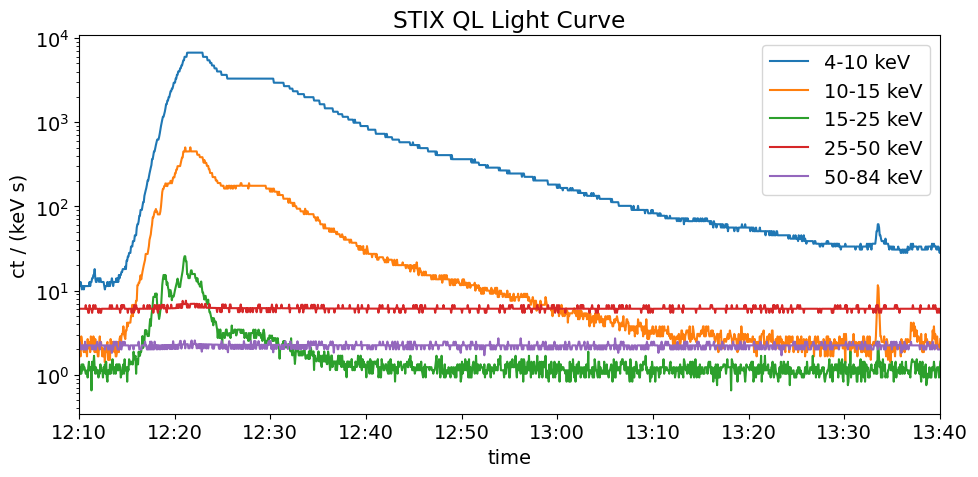

In [4]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
ts.plot(axes=ax)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Prevent x-tick label rotation
plt.setp(ax.get_xticklabels(), rotation=0)
# Center-align the labels
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
fig.tight_layout()
plt.show()

In [7]:
### Both methods are the same ...

# do timedelay correction and convert to datetime objects
df = ts.to_dataframe()
files = fits.open(ql_lc_files[0])
correct_times = ts.time + (files[0].header['EAR_TDEL'])*u.s
ql_shift_times = correct_times.datetime

# # do timedelay correction and convert to datetime objects
# files = fits.open(ql_lc_files[0])
# ql_shift_times = [t + timedelta(seconds=files[0].header['EAR_TDEL']) for t in ts.time.datetime]

df_filtered = df.filter(items=['4-10 keV','10-15 keV','15-25 keV','25-50 keV','50-84 keV'])

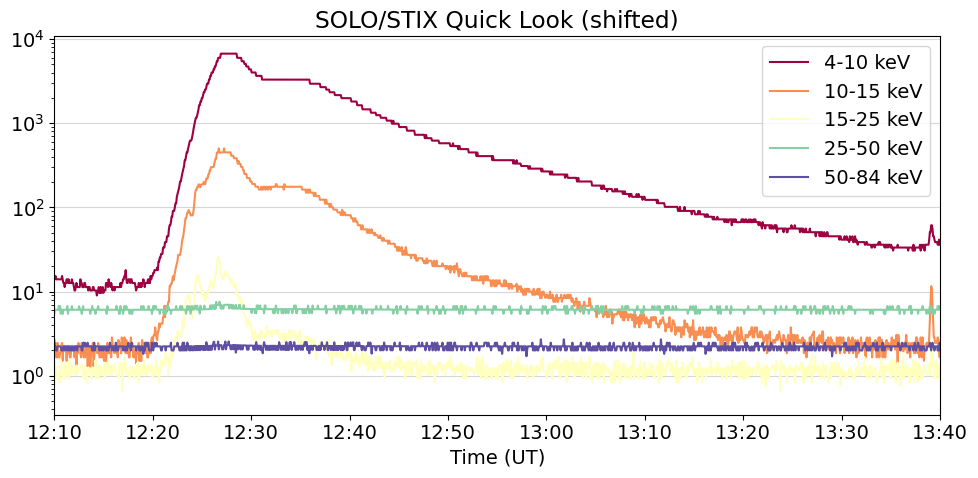

In [9]:
fig = plt.figure(figsize=[10,5])
ax  = fig.add_subplot(111)

cmap        = plt.cm.get_cmap('Spectral') # Spectral, Blues
num_lines   = len(df_filtered.columns)
colors_list = cmap(np.linspace(0, 1, num_lines))

for i, col in enumerate(df_filtered.columns):
    ax.plot(ql_shift_times, df_filtered[col], color=colors_list[i], label=col)

ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
ax.set_title(ts.meta.metas[0]['telescop']+' Quick Look (shifted)')
ax.legend(loc='best')
ax.grid(axis='y', alpha=0.5)
ax.set_xlim(left=pd.Timestamp(f'{mydate} 12:10'), right=pd.Timestamp(f'{mydate} 13:40'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

NameError: name 'mytuple' is not defined

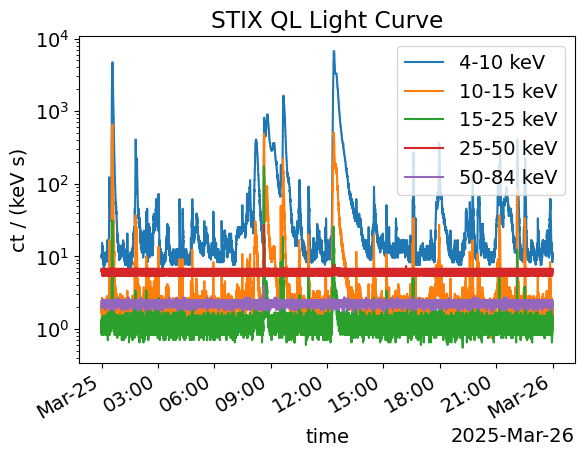

In [10]:
ts.plot()

ax = plt.gca() 
dE = mytuple[4]['e_high'] - mytuple[4]['e_low']
ax.plot(dyspec.times.datetime,
        np.array([dyspec.data['counts'][...,lo:hi].sum(axis=(1))/dyspec.duration.to('s') for lo, hi in [[1,6], [7,11], [12,16], [17,22], [23,27]]]).T/dE)